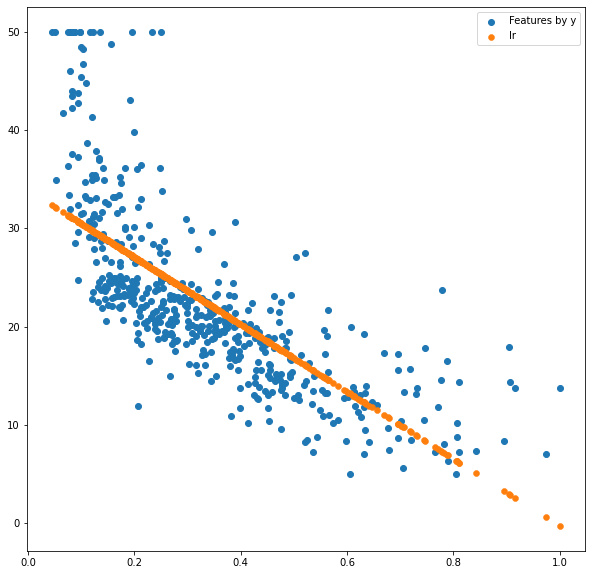

In [53]:
# Регрессия
from IPython.display import clear_output
from sklearn.datasets import load_boston
import torch
from torch import nn
import time
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

boston = load_boston()
x = torch.tensor(boston.data[::, 12] / boston.data[::, 12].max())
y = torch.tensor(boston.target)

w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

time.sleep(5)
for i in range(1000):

    y_pred = x * w + b

    loss = torch.mean((y_pred - torch.tensor(y))**2)
    loss.backward()

    w.data -= .05 * w.grad
    b.data -= .05 * b.grad

    w.grad.data.zero_()
    b.grad.data.zero_()

    w.requires_grad = True
    if i % 30 == 0:
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.scatter(x=x.data.numpy(), y=y.data.numpy(), label='Features by y')
        plt.scatter(x=x.data.numpy(),
                    y=y_pred.data.numpy(),
                    label='lr',
                    linewidth=0.5)
        plt.legend()
        plt.show()
    if loss < 0.1:
        print('1')
        break

In [33]:
# Нейросеть
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": torch.tensor(x[idx, :]), "target": y[idx]}


x = torch.rand(1000, 5)
y = torch.rand(1000)
dataset = Dataset(x, y)
dataset.__getitem__(1)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
batch = next(iter(dataloader))

model = nn.Sequential()
model.add_module("l1", nn.Linear(5, 15))
model.add_module("l2", nn.ReLU())
model.add_module("l3", nn.Linear(15, 1))

another_model = nn.Sequential(nn.Linear(5, 15), nn.ReLU(), nn.Linear(15, 1))

<ipython-input-33-50521cf4410f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"sample": torch.tensor(x[idx, :]), "target": y[idx]}


In [34]:
batch = next(iter(dataloader))
print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[0.7333, 0.0458, 0.8406, 0.8670, 0.3836],
        [0.0409, 0.1727, 0.3836, 0.2678, 0.2629],
        [0.9640, 0.5775, 0.9624, 0.0977, 0.1294],
        [0.6033, 0.3896, 0.0247, 0.8619, 0.1044]])
Target:
tensor([0.9704, 0.2498, 0.2237, 0.5047])


<ipython-input-33-50521cf4410f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"sample": torch.tensor(x[idx, :]), "target": y[idx]}


In [35]:
y_pred = another_model(batch["sample"])
y_pred

tensor([[0.0166],
        [0.1828],
        [0.1347],
        [0.1880]], grad_fn=<AddmmBackward0>)

In [36]:
mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=4,
                                               shuffle=True,
                                               num_workers=1)

val_dataloader = torch.utils.data.DataLoader(mnist_val,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist/MNIST\raw



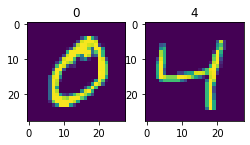

In [41]:
for i in [1, 2]:
    plt.subplot(1, 3, i+1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [ ]:
model = nn.Sequential(
    nn.Flatten(),            # transform a picture 28x28 to tensor with shape == 784 
    nn.Linear(28*28, 128),   # linear layer for reshape vector from 784 to 128
    nn.ReLU(),               # nonlinear layer - max(0, x)
    nn.Linear(128, 10)       # linear layer for probability output
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
[x for x in model.named_parameters()]

In [54]:
for epoch in range(5):
    for x_train, y_train in tqdm(train_dataloader):
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    if epoch % 2 == 0:
        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                y_pred = model(x_val)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 264.09it/s]


Epoch: 0, loss: 0.08438032120466232, accuracy: 0.9741


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 288.08it/s]


Epoch: 2, loss: 0.0725444108247757, accuracy: 0.9777


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 266.52it/s]

Epoch: 4, loss: 0.0785910114645958, accuracy: 0.9768


In [59]:
model(x_train[:1]).max()

tensor(12.7552, grad_fn=<MaxBackward1>)

In [70]:
print(np.argmax(model(x_train[:1]).tolist())

1

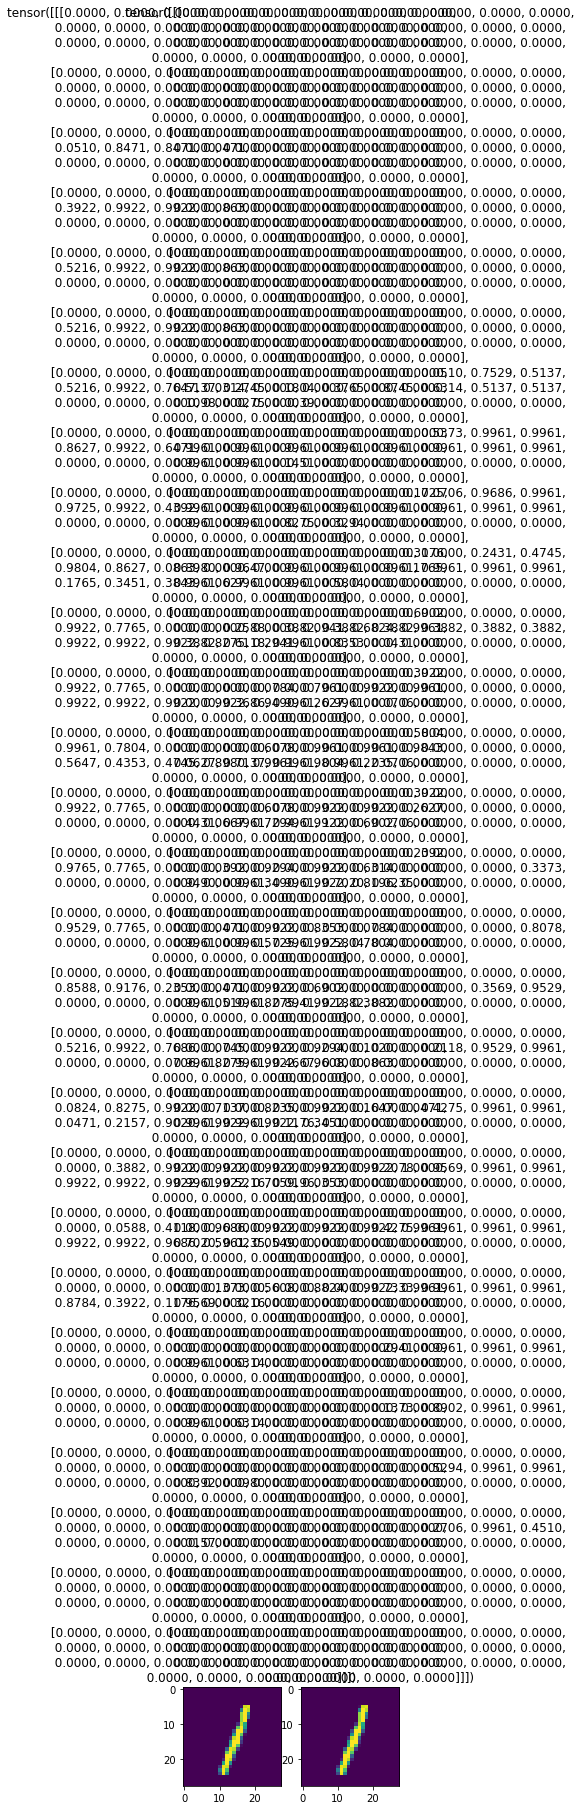

In [72]:
plt.subplot(1, 3, i+1)
plt.imshow(x_train[:1].squeeze(0).numpy().reshape([28, 28]))
plt.title(str(x_train[i]))
plt.show()

[[-7.9999165534973145,
  12.75521469116211,
  -0.010159820318222046,
  -1.192653775215149,
  4.678091526031494,
  -6.016168117523193,
  -6.269726753234863,
  7.303784370422363,
  0.7204354405403137,
  -2.278658866882324]]